# MODEL 3 Version 2.3.2.4
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
### Accounts for last three noisy volumes via FSL ROI -- removal and recreation of EPI files
### Considers only 11/11 window data

#  WMAZE Beta Series correlation Analysis

## Obtains Correlation values for the regions of interest:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC (FS labels: rostral anterior cingulate [1026, 2026] & caudal anterior cingulate [1002, 2002])
### Dorsolateral PFC (Lausanne atlas: dlPFC)

### Use Glob to grab all previously created anatomy masks and beta series cope files

In [15]:
from glob import glob

#Removed WMAZE_006 and WMAZE_023 
#Removed WMAZE_006 and WMAZE_023 
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    # Grab the mask files for each subject
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/model3_betaseries/mask/anat_masks/_subject_id_' 
                               + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    # Grab the cope files for each subject
    subjcopes_glob = glob(proj_dir + '/frstlvl/wmaze_MRthesis/fixed_before_conditional/model3_2-3-2-4/11-11window/merge_copes/'
                          + SID + '/merged/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    # If there are no cope files, print subject id
    if len(cope_files[-1]) == 0:
        print(SID)

### Cell to double-check the array indexing for both the masks and the copes

In [16]:
for i, curr_mask in enumerate(mask_filenames[0]):
    print(i, mask_filenames[0][i].split('/')[-1][:-7])

(0, 'lh-dlPFC_lausanne_warped')
(1, 'lh-hippocampus_warped')
(2, 'lh-mPFC_fs-3reg_warped')
(3, 'lh-mPFC_lausanne_warped')
(4, 'lh-mPFC_rac-only_warped')
(5, 'lh-mPFC_warped')
(6, 'lh-motor_warped')
(7, 'lh-putamen_warped')
(8, 'lh_caudate_anat_mask_warped')
(9, 'rh-dlPFC_lausanne_warped')
(10, 'rh-hippocampus_warped')
(11, 'rh-mPFC_warped')
(12, 'rh-putamen_warped')
(13, 'rh_caudate_anat_mask_warped')
(14, 'rh-mPFC_fs-3reg_warped')
(15, 'rh-mPFC_lausanne_warped')
(16, 'rh-mPFC_rac-only_warped')
(17, 'rh-motor_warped')
(18, 'lh-mPFC_rac-cac_warped')
(19, 'rh-mPFC_rac-cac_warped')


### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [41]:
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lh_hp_after11':[], 'rh_hp_after11':[], 
            'lh_hp_during11':[], 'rh_hp_during11':[],                 
            'lh_caudate_after11':[], 'rh_caudate_after11':[], 
            'lh_caudate_during11':[], 'rh_caudate_during11':[],  
            'lh_dlPFC_after11':[], 'rh_dlPFC_after11':[], 
            'lh_dlPFC_during11':[], 'rh_dlPFC_during11':[],            
            'lh_mPFC_after11':[], 'rh_mPFC_after11':[], 
            'lh_mPFC_during11':[], 'rh_mPFC_during11':[]}

corr_matrix = np.zeros((len(sids), 5))

# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][1])
    rh_hp_img = nb.load(mask_filenames[i][10])
    
    lh_caudate_img = nb.load(mask_filenames[i][8])
    rh_caudate_img = nb.load(mask_filenames[i][13])
    
    lh_dlPFC_img = nb.load(mask_filenames[i][0])
    rh_dlPFC_img = nb.load(mask_filenames[i][9])
    
    lh_mPFC_img = nb.load(mask_filenames[i][1])
    rh_mPFC_img = nb.load(mask_filenames[i][13])
    
    #Load copes for after11 vs during11 betas
    cope_after11_img = nb.load(cope_files[i][0])
    cope_during11_img = nb.load(cope_files[i][1])
     
  
    ########################
    ### Left Hippocampus ###
    ########################
    
    # cope_after11
    lh_hp_after11_data = cope_after11_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_after11'].append(lh_hp_after11_data[0:-1])
    
    # cope_during11
    lh_hp_during11_data = cope_during11_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_during11'].append(lh_hp_during11_data[0:-1])
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # cope_after11
    rh_hp_after11_data = cope_after11_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_after11'].append(rh_hp_after11_data[0:-1])

    # cope_during11
    rh_hp_during11_data = cope_during11_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_during11'].append(rh_hp_during11_data[0:-1])
    
    #####################
    ### Left Caudate ###
    ##################### 
    
    # cope_after11
    lh_caudate_after11_data = cope_after11_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_after11'].append(lh_caudate_after11_data[0:-1])

    # cope_during11
    lh_caudate_during11_data = cope_during11_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_during11'].append(lh_caudate_during11_data[0:-1])
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # cope_after11
    rh_caudate_after11_data = cope_after11_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_after11'].append(rh_caudate_after11_data[0:-1])

    # cope_during11
    rh_caudate_during11_data = cope_during11_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_during11'].append(rh_caudate_during11_data[0:-1])  
    
    ####################
    #### Left mPFC #####
    ####################
    
    # cope_after11
    lh_mPFC_after11_data = cope_after11_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_after11'].append(lh_mPFC_after11_data[0:-1])
    
    # cope_during11
    lh_mPFC_during11_data = cope_during11_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_during11'].append(lh_mPFC_during11_data[0:-1])    
    
    #####################
    #### Right mPFC #####
    #####################
    
    # cope_after11
    rh_mPFC_after11_data = cope_after11_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_after11'].append(rh_mPFC_after11_data[0:-1])

    # cope_during11
    rh_mPFC_during11_data = cope_during11_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_during11'].append(rh_mPFC_during11_data[0:-1]) 
    
    ####################
    #### Left dlPFC ####
    ####################
    
    # cope_after11
    lh_dlPFC_after11_data = cope_after11_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_after11'].append(lh_dlPFC_after11_data[0:-1])
    
    # cope_during11
    lh_dlPFC_during11_data = cope_during11_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_during11'].append(lh_dlPFC_during11_data[0:-1])  
    
    #####################
    ### Right dlPFC ###
    #####################
    
    # cope_after11
    rh_dlPFC_after11_data = cope_after11_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_after11'].append(rh_dlPFC_after11_data[0:-1])

    # cope_during11
    rh_dlPFC_during11_data = cope_during11_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_during11'].append(rh_dlPFC_during11_data[0:-1])    
    
    #array with keys for each part of all_data dictionary
    all_keys = ['lh_hp_after11', 'rh_hp_after11', 
                'lh_hp_during11', 'rh_hp_during11',                 
                'lh_caudate_after11', 'rh_caudate_after11', 
                'lh_caudate_during11', 'rh_caudate_during11',  
                'lh_dlPFC_after11', 'rh_dlPFC_after11', 
                'lh_dlPFC_during11', 'rh_dlPFC_during11',            
                'lh_mPFC_after11', 'rh_mPFC_after11', 
                'lh_mPFC_during11', 'rh_mPFC_during11']
    
    for key in all_keys: 
        # averaging each column for only the current participant 
        all_data[key][-1] = np.mean(all_data[key][-1], axis = 0)
       
    #Combined Hippocampus average for after11 and during11 for current sub
    all_data['hp_after11'] = (np.array(all_data['lh_hp_after11'][-1]) + 
                              np.array(all_data['rh_hp_after11'][-1]))/2.
    all_data['hp_during11'] = (np.array(all_data['lh_hp_during11'][-1]) + 
                               np.array(all_data['rh_hp_during11'][-1]))/2.
                             
    #Combined Caudate average for after11 and during11 for current sub
    all_data['caudate_after11'] = (np.array(all_data['lh_caudate_after11'][-1]) + 
                                   np.array(all_data['rh_caudate_after11'][-1]))/2.
    all_data['caudate_during11'] = (np.array(all_data['lh_caudate_during11'][-1]) + 
                                    np.array(all_data['rh_caudate_during11'][-1]))/2.

    # Combined mPFC average for after11 and during11 for current sub
    all_data['mPFC_after11'] = (np.array(all_data['lh_mPFC_after11'][-1]) + 
                                np.array(all_data['rh_mPFC_after11'][-1]))/2.
    all_data['mPFC_during11'] = (np.array(all_data['lh_mPFC_during11'][-1]) + 
                                 np.array(all_data['rh_mPFC_during11'][-1]))/2.

    #Combined dlPFC average for after11 and during11 for current sub
    all_data['dlPFC_after11'] = (np.array(all_data['lh_dlPFC_after11'][-1]) + 
                                 np.array(all_data['rh_dlPFC_after11'][-1]))/2.
    all_data['dlPFC_during11'] = (np.array(all_data['lh_dlPFC_during11'][-1]) + 
                                  np.array(all_data['rh_dlPFC_during11'][-1]))/2.   
   
    
    # Creation of the correlation matrix (with subject id column)
    corr_matrix[i][0] = float(sids[i][-3:])
    corr_matrix[i][1] = stats.pearsonr(all_data['hp_after11'], all_data['mPFC_after11'])[0]
    corr_matrix[i][2] = stats.pearsonr(all_data['hp_during11'], all_data['mPFC_during11'])[0]
    corr_matrix[i][3] = stats.pearsonr(all_data['caudate_after11'], all_data['dlPFC_after11'])[0]
    corr_matrix[i][4] = stats.pearsonr(all_data['caudate_during11'], all_data['dlPFC_during11'])[0]

In [43]:
print all_data['lh_dlPFC_after11'][-1]

[  8.40380096  -8.62128639 -10.81616783  23.09667587 -32.55081177
   1.34153926 -12.02800274 -12.16780567 -13.90763378   3.42003775
  -4.4815321 ]


##  Non-normalized correlation matrix for beta series

In [25]:
import pandas as pd
#create Pandas dataframe to store correlations
correlation_chart = {}
correlation_chart['HPC-mPFC_after11'] = corr_matrix[:, 1] #hpc-mpfc after11
correlation_chart['HPC-mPFC_during11'] = corr_matrix[:, 2] #hpc-mpfc during11
correlation_chart['Caudate-dlPFC_after11'] = corr_matrix[:, 3] #caudate-dlpfc after11
correlation_chart['Caudate-dlPFC_during11'] = corr_matrix[:, 4] #caudate-dlpfc during11
correlation_chart_df = pd.DataFrame.from_dict(correlation_chart)

In [26]:
correlation_chart_df

,Caudate-dlPFC_after11,Caudate-dlPFC_during11,HPC-mPFC_after11,HPC-mPFC_during11
0,0.460766,0.440489,0.810134,0.713998
1,0.908796,0.394611,0.975374,0.770179
2,0.664353,0.289967,0.725598,0.761464
3,0.595715,0.284513,0.760401,0.765271
4,0.779449,0.377280,0.785094,0.733541
5,0.821764,0.815392,0.915378,0.732639
6,0.700218,0.641753,0.853678,0.553237
7,0.193750,0.692863,0.481192,0.677939
8,0.639865,0.525240,0.507341,0.836089
9,0.591090,0.821668,0.738806,0.948062



T-test: HPC-mPFC_after11 vs. HPC-mPFC_during11
Ttest_relResult(statistic=0.51631995402936215, pvalue=0.61228187335807727)

T-test: Caudate-dlPFC_after11 vs. Caudate-dlPFC_during11
Ttest_relResult(statistic=-1.3460470133995992, pvalue=0.19596401911087558)



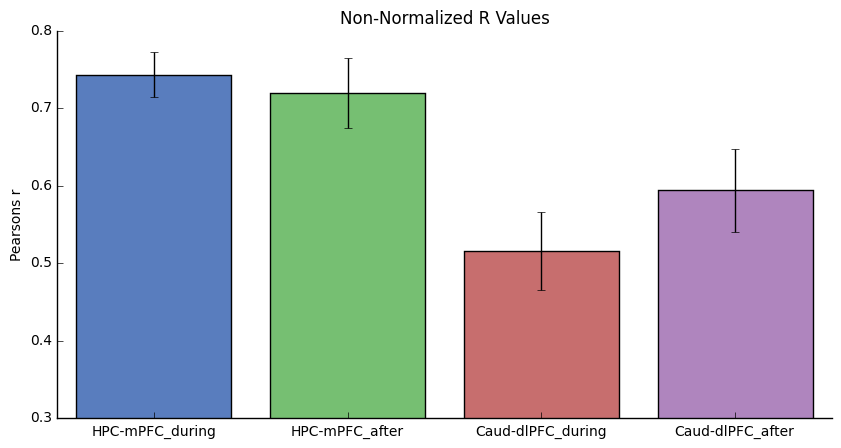

In [27]:
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_during', 'HPC-mPFC_after', 'Caud-dlPFC_during', 'Caud-dlPFC_after']
means_allsubjs = [np.average(correlation_chart['HPC-mPFC_during11']),
                  np.average(correlation_chart['HPC-mPFC_after11']),
                  np.average(correlation_chart['Caudate-dlPFC_during11']),
                  np.average(correlation_chart['Caudate-dlPFC_after11'])]
sem_allsubjs = [stats.sem(correlation_chart['HPC-mPFC_during11']),
                stats.sem(correlation_chart['HPC-mPFC_after11']),
                stats.sem(correlation_chart['Caudate-dlPFC_during11']),
                stats.sem(correlation_chart['Caudate-dlPFC_after11'])]


print ""
print 'T-test: HPC-mPFC_after11 vs. HPC-mPFC_during11'
print stats.ttest_rel(correlation_chart['HPC-mPFC_during11'], correlation_chart['HPC-mPFC_after11'])
print ""

print 'T-test: Caudate-dlPFC_after11 vs. Caudate-dlPFC_during11'
print stats.ttest_rel(correlation_chart['Caudate-dlPFC_during11'], correlation_chart['Caudate-dlPFC_after11'])
print ""

ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots(figsize=(10,5))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
ax.set_ylim(0.3,0.8)
ax.set_ylabel("Pearsons r")
#ax.set_xlabel("Regional Correlations")
ax.set_title("Non-Normalized R Values")
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/11-11_bar.jpg")
plt.show()

In [13]:
N = 4
conditions = ['HPC-mPFC During', 'HPC-mPFC After', 'Caud-dlPFC During', 'Caud-dlPFC After']

means_allsubjs = [np.average(correlation_chart['HPC-mPFC_during11']),
                  np.average(correlation_chart['HPC-mPFC_after11']),
                  np.average(correlation_chart['Caudate-dlPFC_during11']),
                  np.average(correlation_chart['Caudate-dlPFC_after11'])]
sem_allsubjs = [stats.sem(correlation_chart['HPC-mPFC_during11']),
                stats.sem(correlation_chart['HPC-mPFC_after11']),
                stats.sem(correlation_chart['Caudate-dlPFC_during11']),
                stats.sem(correlation_chart['Caudate-dlPFC_after11'])]

fig, ax = plt.subplots()
pal = ["#7030a0", "#f79646", "#7030a0", "#f79646"]
pal = sns.color_palette(pal)
pal2 = ["#347ff9", "#347ff9", "#f9f96d", "#f9f96d"]
pal2 = sns.color_palette(pal2)
:   
sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, palette = pal2, 
            ecolor = 'black', edgecolor = pal, linewidth = 4)
ax.set_xticklabels(conditions)
ax.set_ylabel('')
ax.set_ylim(0.3,0.8)
plt.tight_layout()
plt.savefig("/home/data/madlab/scripts/wmaze/anal_MR_thesis/fixed_before_conditional/model3/11-11window.jpg")
plt.show()

SyntaxError: invalid syntax (<ipython-input-13-4f0015be896d>, line 18)

In [ ]:
print np.average(correlation_chart['HPC-mPFC_after11'])
print np.average(correlation_chart['HPC-mPFC_during11'])
print np.average(correlation_chart['Caudate-dlPFC_after11'])
print np.average(correlation_chart['Caudate-dlPFC_during11'])
print ""
print np.std(correlation_chart['HPC-mPFC_after11'])
print np.std(correlation_chart['HPC-mPFC_during11'])
print np.std(correlation_chart['Caudate-dlPFC_after11'])
print np.std(correlation_chart['Caudate-dlPFC_during11'])

print 'HPC-mPFC During 11', stats.normaltest(correlation_chart['HPC-mPFC_during11'])[:]
print 'HPC-mPFC After 11', stats.normaltest(correlation_chart['HPC-mPFC_after11'])[:]
print ""
print 'Caudate-dlPFC During 11', stats.normaltest(correlation_chart['Caudate-dlPFC_during11'])[:]
print 'Caudate-dlPFC After 11', stats.normaltest(correlation_chart['Caudate-dlPFC_after11'])[:]

## Normalized correlation matrix for beta series

In [ ]:
# Use Numpy's arctangent function to normalize correlations
norm_corr = np.arctanh(corr_matrix[:, 1:])
#print(norm_after11)

In [ ]:
import pandas as pd
norm_chart = {}
norm_chart['HPC-mPFC_after11'] = norm_corr[:, 0] #hpc-mpfc after11
norm_chart['HPC-mPFC_during11'] = norm_corr[:, 1] #hpc-mpfc during11
norm_chart['Caudate-dlPFC_after11'] = norm_corr[:, 2] #caudate-dlpfc after11
norm_chart['Caudate-dlPFC_during11'] = norm_corr[:, 3] #caudate-dlpfc during11
norm_chart_df = pd.DataFrame.from_dict(norm_chart)

In [ ]:
norm_chart_df

### Descriptive Statistics

In [ ]:
print "Mean: HPC-mPFC_after11"
print np.average(norm_corr[:, 0])
print "SD: HPC-mPFC_after11"
print stats.sem(norm_corr[:, 0])
print ""
print "Mean: HPC-mPFC_during11"
print np.average(norm_corr[:, 1])
print "SD: HPC-mPFC_during11"
print stats.sem(norm_corr[:, 1])
print ""
print "Mean: Caudate-dlPFC_after11"
print np.average(norm_corr[:, 2])
print "SD: Caudate-dlPFC_after11"
print stats.sem(norm_corr[:, 2])
print ""
print "Mean: Caudate-dlPFC_during11"
print np.average(norm_corr[:, 3])
print "SD: Caudate-dlPFC_during11"
print stats.sem(norm_corr[:, 3])

### Inferential Statistics

In [ ]:
print 'T-test: HPC-mPFC_after11 vs. HPC-mPFC_during11'
print stats.ttest_rel(norm_corr[:, 0], norm_corr[:, 1])
print ""

print 'T-test: Caudate-dlPFC_after11 vs. Caudate-dlPFC_during11'
print stats.ttest_rel(norm_corr[:, 2], norm_corr[:, 3])
print ""

print "Bonferroni after11ection"
print '0.05/2 = 0.025'

## Scatterplots illustrating regional activation across trials: Single subject

### Hippocampus & mPFC: Fixed During vs. After Learning

In [ ]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0, 11, 1):
    ax.append(a)
x = ax

#print len(x)
y = all_data['hp_during11'] #blue
z = all_data['mPFC_during11'] #purple
a = all_data['hp_after11'] #blue
b = all_data['mPFC_after11'] #purple

print i

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
#fit = np.polyfit(x, y, deg = 1)
ax.plot(x, y, color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
#fit2 = np.polyfit(x, z, deg = 1)
ax.plot(x, z, color = 'purple')
ax.scatter(x, z, c = 'purple', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('During Learning')
ax.legend(['Hippocampus', 'mPFC'], loc=4)


#fit3 = np.polyfit(x, a, deg = 1) 
ax2.plot(x, a, color = 'blue')
ax2.scatter(x, a, c = 'blue', alpha = 0.5)
#fit4 = np.polyfit(x, b, deg = 1)
ax2.plot(x, b, color = 'purple')
ax2.scatter(x, b, c = 'purple', alpha = 0.5)
ax2.set_xlabel('Trials')
ax2.set_title('After Learning')
ax2.legend(['Hippocampus', 'mPFC'], loc=4)
plt.show()

### Caudate & dlPFC: Fixed During vs. After Learning

In [ ]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0, 11, 1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_during11'] #blue
z = all_data['dlPFC_during11'] #purple
a = all_data['caudate_after11'] #blue
b = all_data['dlPFC_after11'] #purple

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
#fit = np.polyfit(x, y, deg = 1)
ax.plot(x, y, color = 'blue')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
#fit2 = np.polyfit(x, z, deg = 1)
ax.plot(x, z, color = 'purple')
ax.scatter(x, z, c = 'purple', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('During Learning')
ax.legend(['Caudate', 'dlPFC'], loc=4)


#fit3 = np.polyfit(x, a, deg = 1)
ax2.plot(x, a, color = 'blue')
ax2.scatter(x, a, c = 'blue', alpha = 0.5)
#fit4 = np.polyfit(x, b, deg = 1)
ax2.plot(x, b, color = 'purple')
ax2.scatter(x, b, c = 'purple', alpha = 0.5)
ax2.set_xlabel('Trials')
ax2.set_title('After Learning')
ax2.legend(['Caudate', 'dlPFC'], loc=4)
plt.show()